In [4]:
def compute_cosine_sim(v1, v2):
    # Normalize the gradients
    norms = v1.norm(dim=1, keepdim=True)  # Compute norms of each vector
    normalized_v1 = v1 / norms  # Normalize gradients

    norms = v2.norm(dim=1, keepdim=True)  # Compute norms of each vector
    normalized_v2 = v2 / norms  # Normalize gradients
    
    # Compute pairwise cosine similarity
    cosine_similarity_matrix = torch.mm(normalized_v1, normalized_v2.t()).float()
    return cosine_similarity_matrix

In [8]:
import numpy as np 
import os 
import torch 
from tqdm import tqdm

def record_similarity_w_self(file_paths):
    sims = []
    for f in tqdm(file_paths):
        row_sims = []
        loaded_tensor_1 = torch.stack(torch.load(f), dim=0).to("cuda").float()
        for f2 in file_paths:
            loaded_tensor_2 = torch.stack(torch.load(f2), dim=0).to("cuda").float()
            cos_sim = compute_cosine_sim(loaded_tensor_1, loaded_tensor_2)
            row_sims.append((cos_sim).cpu().numpy())
        sims.append(row_sims)
    return np.block(sims)

In [9]:
import numpy as np
import heapq
from tqdm import tqdm

def lazy_greedy_facility_location(S, k):
    """
    Applies the lazy greedy algorithm to solve the facility location problem
    using a given similarity matrix.

    Parameters:
    S (np.ndarray): Similarity matrix of shape (n, n).
    k (int): Number of facilities to select.

    Returns:
    list: Indices of the selected facilities.
    """
    n = S.shape[0]
    
    # Initialize m_i (current maximum similarities for each item)
    m = np.zeros(n)
    
    # Initial marginal gains (delta_u)
    delta = S.sum(axis=0)
    
    # Initialize priority queue with negative marginal gains
    heap = [(-delta[u], u) for u in range(n)]
    heapq.heapify(heap)
    selected = []
    
    # Use tqdm to display progress bar
    with tqdm(total=k, desc="Selecting facilities", unit="facility") as pbar:
        while len(selected) < k and heap:
            # Pop the element with the highest marginal gain
            neg_delta_u, u = heapq.heappop(heap)
            # Recompute marginal gain since m_i may have been updated
            delta_u = np.maximum(S[:, u] - m, 0).sum()
            # Check if this is still the best option
            if not heap or delta_u >= -heap[0][0]:
                # Accept u
                selected.append(u)
                # Update m_i
                m = np.maximum(m, S[:, u])
                # Update the progress bar
                pbar.update(1)
            else:
                # Update the marginal gain and reinsert into the heap
                heapq.heappush(heap, (-delta_u, u))
    
    return selected

# Example usage:
if __name__ == "__main__":
    # Example similarity matrix
    S = np.array([
        [1.0, 0.8, 0.2, 0.1],
        [0.8, 1.0, 0.3, 0.2],
        [0.2, 0.3, 1.0, 0.9],
        [0.1, 0.2, 0.9, 1.0]
    ])
    k = 2
    selected_facilities = lazy_greedy_facility_location(S, k)
    print("Selected facilities:", selected_facilities)


Selecting facilities: 100%|██████████| 2/2 [00:00<00:00, 16100.98facility/s]

Selected facilities: [2, 0]


In [14]:
dir = "/scratch/saved_representations/chartqa/"
file_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if "representations" in f])
file_paths = file_paths[3:] + file_paths[:3]

In [15]:
file_paths

['/scratch/saved_representations/chartqa/representations_cg_gen_1_0.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_1_1.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_1_2.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_2_0.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_2_1.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_2_2.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_3_0.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_3_1.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_3_2.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_4_0.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_4_1.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_4_2.pt',
 '/scratch/saved_representations/chartqa/representations_cg_gen_5_0.pt',
 '/scratch/saved_representations/chartqa/representa

In [16]:
rep_sim = record_similarity_w_self(file_paths)

100%|██████████| 30/30 [02:53<00:00,  5.80s/it]


In [18]:
facility_location_sorted_idx = lazy_greedy_facility_location(rep_sim, len(rep_sim))

Selecting facilities: 100%|██████████| 149960/149960 [27:44<00:00, 90.11facility/s] 


In [20]:
np.mean(rep_sim)

0.72150654

In [27]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/generated_data/chartqa_gen_task_desc_150k_2024_09_18_merged.json", "r") as f:
    data = json.load(f) 

In [28]:
import random 
with open("/home/t-sijoshi/multimodal-data-gen/generated_data/chartqa_gen_task_desc_150k_2024_09_18_merged_subset_rand_75k.json", "w") as f:
    data["samples"] = random.sample(data["samples"], 75000)
    data["len_samples"] = len(data["samples"])
    json.dump(data, f, indent=3)

In [19]:
np.save("subset_idx/chartqa_3_v3_gen_task_desc_150k_facility_location.npy", facility_location_sorted_idx)

In [3]:
import matplotlib.pyplot as plt

_, bins, _patches = plt.hist(torch.flatten(compute_cosine_sim(ref, sky)), label="sim with skyline")
plt.hist(torch.flatten(compute_cosine_sim(ref, gen)), bins=bins, alpha=0.5, label="sim with generated data")
plt.legend()
plt.title("(All) Last Transformer (V Proj Matrix) Representation Similarity")

NameError: name 'sky' is not defined

Text(0.5, 1.0, '(Mean) Last Transformer (V Proj Matrix) Representation Similarity')

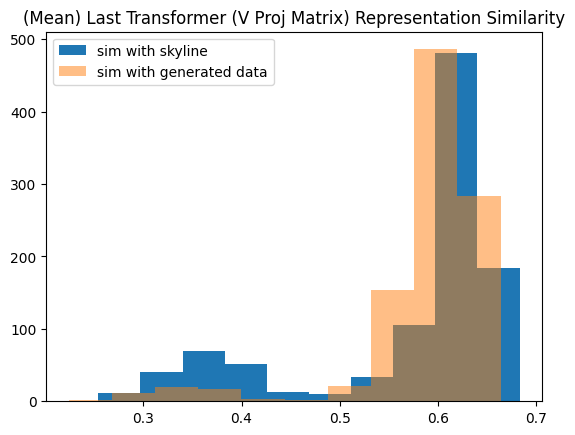

In [13]:
import matplotlib.pyplot as plt

plt.hist(torch.mean(compute_cosine_sim(ref, sky), dim=0), label="sim with skyline")
plt.hist(torch.mean(compute_cosine_sim(ref, gen), dim=0), alpha=0.5, label="sim with generated data")
plt.legend()
plt.title("(Mean) Last Transformer (V Proj Matrix) Representation Similarity")

In [17]:
torch.max(compute_cosine_sim(ref, sky), dim=0).values.shape

torch.Size([1000])

Text(0.5, 1.0, '(Max) Last Transformer (V Proj Matrix) Representation Similarity')

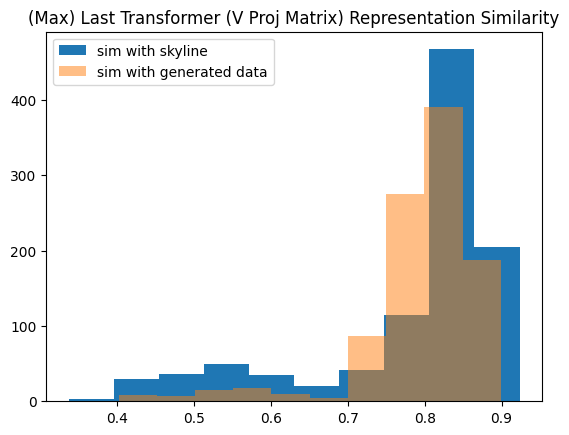

In [14]:
import matplotlib.pyplot as plt

plt.hist(torch.max(compute_cosine_sim(ref, sky), dim=0).values, label="sim with skyline")
plt.hist(torch.max(compute_cosine_sim(ref, gen), dim=0).values, alpha=0.5, label="sim with generated data")
plt.legend()
plt.title("(Max) Last Transformer (V Proj Matrix) Representation Similarity")

(array([  91.,  483., 1556., 4322., 6441., 7399., 2914.,  236.,   42.,
          16.]),
 array([0.07484197, 0.13595055, 0.19705912, 0.25816771, 0.31927627,
        0.38038486, 0.44149345, 0.50260204, 0.56371057, 0.62481916,
        0.68592775]),
 <BarContainer object of 10 artists>)

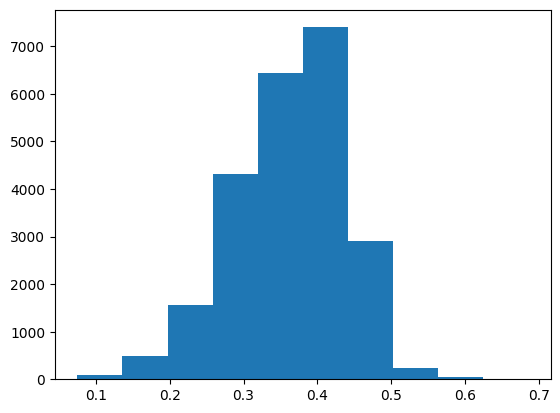

In [14]:
plt.hist(torch.flatten(compute_cosine_sim(ref, gen)))

In [135]:
compute_cosine_sim(ref_gradients, gen_gradients).max(dim=0).values

tensor([0.1943, 0.2217, 0.2852, 0.2451, 0.2354, 0.2275, 0.2539, 0.2617, 0.2520,
        0.2422, 0.2314, 0.2334, 0.2393, 0.1963, 0.1670, 0.1455, 0.1079, 0.0884,
        0.0732, 0.1094, 0.1094, 0.1138, 0.1289, 0.1611, 0.1689, 0.1709, 0.1670,
        0.1680, 0.1631, 0.1475, 0.1465, 0.1328, 0.1602, 0.1621, 0.1592, 0.1484,
        0.1465, 0.1377, 0.1260, 0.1250, 0.1357, 0.1621, 0.1670, 0.1650, 0.1611,
        0.1748, 0.1768, 0.1689, 0.1621, 0.1631, 0.1631, 0.1689, 0.1895, 0.1797,
        0.1895, 0.1758, 0.1748, 0.1738, 0.1670, 0.1768, 0.1631, 0.1689, 0.1689,
        0.1641, 0.1631, 0.1650, 0.1709, 0.1660, 0.1680, 0.1729, 0.1768, 0.1748,
        0.1768, 0.1729, 0.1699, 0.1689, 0.1699, 0.1543, 0.1514, 0.1592, 0.1582,
        0.1582, 0.1562, 0.1631, 0.1670, 0.1582, 0.1562, 0.1533, 0.1602, 0.1621,
        0.1553, 0.1455, 0.1475, 0.1504, 0.1572, 0.1621, 0.1582, 0.1553, 0.1523,
        0.1602, 0.1660, 0.1621, 0.1689, 0.1650, 0.1631, 0.1650, 0.1641, 0.1689,
        0.1621, 0.1650, 0.1582, 0.1602, 

(array([2.300e+01, 8.400e+01, 1.810e+02, 5.580e+02, 2.044e+03, 4.468e+03,
        1.312e+04, 2.915e+03, 9.900e+01, 8.000e+00]),
 array([-0.44726562, -0.37753907, -0.30781251, -0.23808594, -0.16835937,
        -0.09863281, -0.02890625,  0.04082031,  0.11054687,  0.18027344,
         0.25      ]),
 <BarContainer object of 10 artists>)

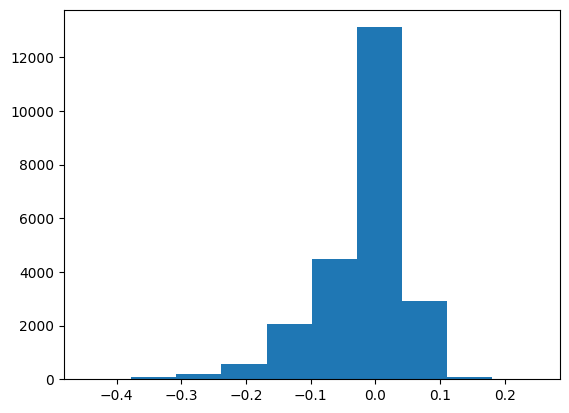

In [136]:
plt.hist(compute_cosine_sim(ref_gradients, test_gradients).flatten())

(array([ 76.,  74.,  66., 208., 284., 344., 244., 192., 280., 441.]),
 array([0.28710938, 0.35917968, 0.43125001, 0.50332034, 0.57539064,
        0.64746094, 0.71953124, 0.79160154, 0.8636719 , 0.9357422 ,
        1.0078125 ]),
 <BarContainer object of 10 artists>)

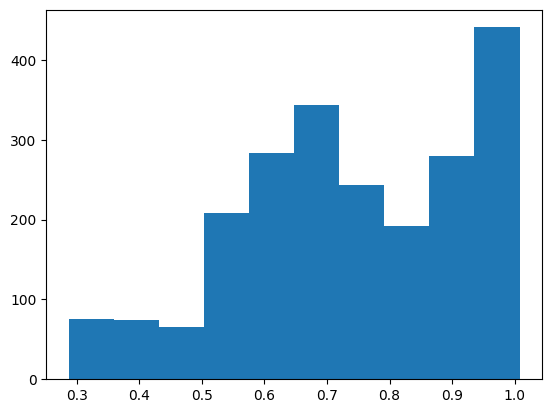

In [137]:
plt.hist(compute_cosine_sim(ref_gradients, ref_gradients).flatten())


(array([4.20000e+01, 1.76000e+02, 7.70000e+02, 2.00000e+00, 5.40000e+01,
        3.32800e+03, 1.26200e+03, 5.19200e+03, 8.34000e+03, 2.30834e+05]),
 array([-0.38085938, -0.24199219, -0.103125  ,  0.03574219,  0.17460938,
         0.31347656,  0.45234376,  0.59121096,  0.7300781 ,  0.8689453 ,
         1.0078125 ]),
 <BarContainer object of 10 artists>)

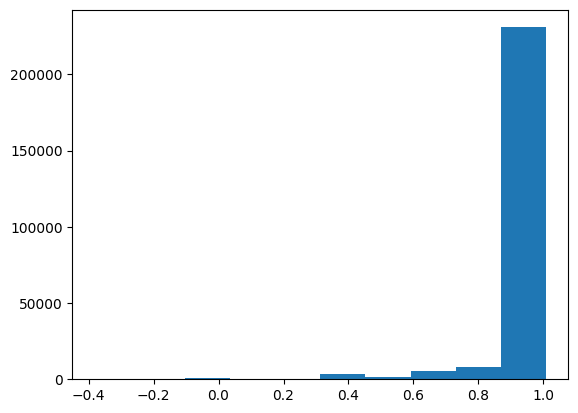

In [138]:
plt.hist(compute_cosine_sim(test_gradients, test_gradients).flatten())


In [129]:
compute_cosine_sim(ref_gradients, test_gradients).mean(dim=0)

tensor([-0.1932, -0.0338, -0.0179, -0.1111, -0.1175, -0.1736, -0.0341, -0.0383,
        -0.0070,  0.0161,  0.0260,  0.0362,  0.0311,  0.0369,  0.0395,  0.0429,
         0.0731,  0.0616,  0.0705,  0.0792,  0.0817,  0.0881,  0.0920,  0.1145,
         0.1087,  0.1068,  0.1012,  0.1005,  0.1034,  0.0990,  0.1030,  0.1048,
         0.1046,  0.1021,  0.1047,  0.1055,  0.1149,  0.1134,  0.1118,  0.1133,
         0.1192,  0.1215,  0.1504,  0.1396,  0.1429,  0.1442,  0.1455,  0.1475,
         0.1387,  0.1407,  0.1418,  0.1474,  0.1467,  0.1592,  0.1659,  0.1660,
         0.1621,  0.1615,  0.1632,  0.1559,  0.1538,  0.1456,  0.1485,  0.1490,
         0.1621,  0.1550,  0.1485,  0.1673,  0.1912,  0.1919,  0.1880,  0.1894,
         0.1900,  0.1868,  0.1883,  0.1921,  0.1957,  0.1955,  0.1987,  0.1986,
         0.1864,  0.1864,  0.1883,  0.1893,  0.2004,  0.1977,  0.2041,  0.2092,
         0.1989,  0.1989,  0.1988,  0.2001,  0.2013,  0.2051,  0.2055,  0.2031,
         0.2032,  0.2034,  0.2251,  0.22

In [128]:
compute_cosine_sim(ref_gradients, gen_gradients).max(dim=0).indices

tensor([41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,
         5.,  3.,  5.,  1.,  2.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  4.,
         8.,  7.,  5.,  6., 10., 19.,  9.,  7., 34., 16., 18., 27., 52.,
        56., 45., 45., 28., 10., 11., 23.,  3., 15.]),
 array([-0.13378906, -0.12965821, -0.12552734, -0.12139648, -0.11726563,
        -0.11313476, -0.10900391, -0.10487305, -0.10074219, -0.09661133,
        -0.09248047, -0.08834961, -0.08421875, -0.08008789, -0.07595703,
        -0.07182617, -0.06769531, -0.06356445, -0.05943359, -0.05530274,
        -0.05117188, -0.04704101, -0.04291015, -0.0387793 , -0.03464844,
        -0.03051758, -0.02638672, -0.02225586, -0.018125  , -0.013994

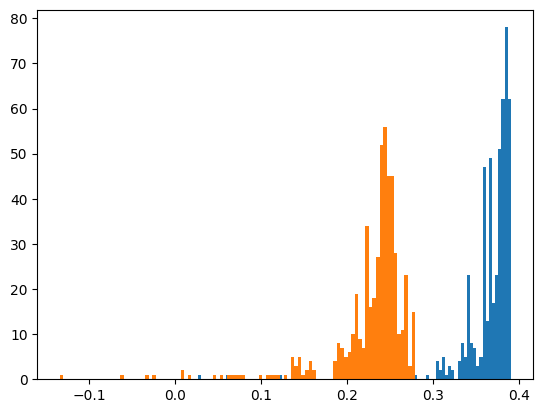

In [123]:
import matplotlib.pyplot as plt

plt.hist(compute_cosine_sim(ref_gradients, gen_gradients).max(dim=0).values, 100)
plt.hist(compute_cosine_sim(ref_gradients, test_gradients).max(dim=0).values, 100)

(array([3.0000e+01, 4.4000e+01, 1.1200e+02, 1.3000e+02, 5.2000e+01,
        4.5000e+01, 2.4000e+01, 4.0000e+00, 1.2000e+01, 1.9000e+01,
        9.1000e+01, 5.3400e+02, 2.8100e+02, 4.2000e+01, 2.2000e+01,
        1.5000e+01, 1.3000e+01, 6.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 1.7000e+01, 3.5000e+01, 1.1300e+02, 1.7200e+02,
        1.0400e+02, 2.6000e+01, 1.9000e+01, 5.3000e+01, 5.0000e+01,
        1.5900e+02, 1.3300e+02, 7.1000e+01, 3.1000e+01, 1.3000e+01,
        1.3800e+02, 1.6000e+02, 1.3400e+02, 1.6700e+02, 1.4300e+02,
        2.2200e+02, 2.2700e+02, 1.6500e+02, 2.1500e+02, 2.1200e+02,
        1.1600e+02, 1.4400e+02, 7.2000e+01, 1.3500e+02, 1.0000e+02,
        3.4000e+01, 2.1000e+01, 7.0000e+00, 1.5000e+01, 7.3000e+01,
        1.8800e+02, 4.1400e+02, 4.7000e+02, 9.53

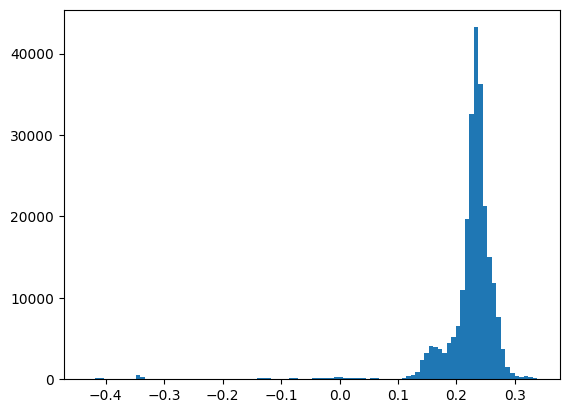

In [122]:
import matplotlib.pyplot as plt

plt.hist(compute_cosine_sim(test_gradients, gen_gradients).flatten(), 100)

In [1]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/generated_data/chartqa_gen_task_desc_150k_2024_09_18_merged.json", "r") as f:
    data = json.load(f)


In [4]:
len(data["samples"])

chunks = [data["samples"][i:i + len(data["samples"]) // 10] for i in range(0, len(data["samples"]), len(data["samples"]) // 10)]

In [5]:
from copy import deepcopy 

curr_data = deepcopy(data)

for i, chunk in enumerate(chunks):
    curr_data["samples"] = chunk
    curr_data["len_samples"] = len(chunk)
    with open(f"/home/t-sijoshi/multimodal-data-gen/generated_data/chartqa_gen_task_desc_150k_2024_09_18_merged_split_{i+1}.json", "w") as f:
        json.dump(curr_data, f, indent=3)

In [12]:
from tqdm import tqdm
import torch 
import os 
import numpy as np 

def compute_cosine_sim(v1, v2):
    # Normalize the gradients
    norms = v1.norm(dim=1, keepdim=True)  # Compute norms of each vector
    normalized_v1 = v1 / norms  # Normalize gradients

    norms = v2.norm(dim=1, keepdim=True)  # Compute norms of each vector
    normalized_v2 = v2 / norms  # Normalize gradients
    
    # Compute pairwise cosine similarity
    cosine_similarity_matrix = torch.mm(normalized_v1, normalized_v2.t()).float()
    return cosine_similarity_matrix

def record_similarity_w_self(file_paths):
    sims = []
    for f in tqdm(file_paths):
        row_sims = []
        loaded_tensor_1 = torch.stack(torch.load(f), dim=0).to("cuda").float()
        for f2 in file_paths:
            loaded_tensor_2 = torch.stack(torch.load(f2), dim=0).to("cuda").float()
            cos_sim = compute_cosine_sim(loaded_tensor_1, loaded_tensor_2)
            row_sims.append((cos_sim).cpu().numpy())
        sims.append(row_sims)
    return np.block(sims) 

In [13]:
file_paths = []
for f in os.listdir("/scratch/saved_representations/chartqa"):
    file_paths.append(os.path.join("/scratch/saved_representations/chartqa", f))

In [21]:
torch.stack(torch.load(file_paths[0]), dim=0).shape

torch.Size([5000])

In [19]:
rep_sim = record_similarity_w_self(file_paths)

  0%|          | 0/30 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [11]:
import numpy as np
import heapq
from tqdm import tqdm

def lazy_greedy_facility_location(S, k):
    """
    Applies the lazy greedy algorithm to solve the facility location problem
    using a given similarity matrix.

    Parameters:
    S (np.ndarray): Similarity matrix of shape (n, n).
    k (int): Number of facilities to select.

    Returns:
    list: Indices of the selected facilities.
    """
    n = S.shape[0]
    
    # Initialize m_i (current maximum similarities for each item)
    m = np.zeros(n)
    
    # Initial marginal gains (delta_u)
    delta = S.sum(axis=0)
    
    # Initialize priority queue with negative marginal gains
    heap = [(-delta[u], u) for u in range(n)]
    heapq.heapify(heap)
    selected = []
    
    # Use tqdm to display progress bar
    with tqdm(total=k, desc="Selecting facilities", unit="facility") as pbar:
        while len(selected) < k and heap:
            # Pop the element with the highest marginal gain
            neg_delta_u, u = heapq.heappop(heap)
            # Recompute marginal gain since m_i may have been updated
            delta_u = np.maximum(S[:, u] - m, 0).sum()
            # Check if this is still the best option
            if not heap or delta_u >= -heap[0][0]:
                # Accept u
                selected.append(u)
                # Update m_i
                m = np.maximum(m, S[:, u])
                # Update the progress bar
                pbar.update(1)
            else:
                # Update the marginal gain and reinsert into the heap
                heapq.heappush(heap, (-delta_u, u))
    
    return selected

In [ ]:
sim = record_similarity_w_self("representations_cqa", start=0, stop=10)